In [511]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [512]:
from google.colab import drive
drive.mount('/content/drive')

# daily stock history of amazon
data = pd.read_csv('/content/drive/MyDrive/AMZN.csv')
print(f'No of rows: {data.shape[0]}\nNo of cols: {data.shape[1]}\n{data.columns}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
No of rows: 6516
No of cols: 7
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [513]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


In [514]:
 device = 'cuda' if torch.cuda.is_available() else 'cpu'
 device

'cuda'

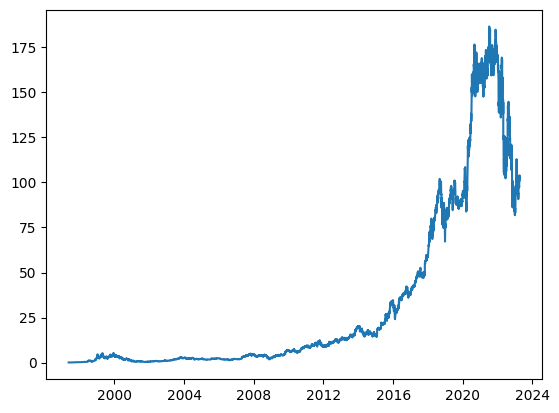

In [515]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

In [516]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df,n_steps):
    df = dc(df)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    for i in range(1, n_steps):
      df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6)
Date,,,,,,,
1997-05-23,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997


In [517]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[7.50000000e-02, 6.97920000e-02, 7.13540000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.02000000e+02, 1.00250000e+02, 9.72399980e+01]])

In [518]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.99995531, -1.        , -0.99998325, ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99991063, -0.99994415, -1.        , ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99993855, -0.99989946, -0.99994415, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10691495,  0.09308121, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.11398769,  0.09747802,  0.10691495, ...,  0.07431453,
         0.04203581,  0.0506149 ],
       [ 0.08342464,  0.11399263,  0.09747802, ...,  0.09308121,
         0.07431453,  0.04203581]])

In [519]:
X = shifted_df_as_np[:,1:]
y = shifted_df_as_np[:,0]

print(X.shape, y.shape)

(6510, 6) (6510,)


In [520]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, -0.99987154, -0.99998325,
        -1.        ],
       [-0.99982128, -0.99983244, -0.99987154, -0.99998325, -1.        ,
        -0.99994415],
       [-0.99983244, -0.99987154, -0.99998325, -1.        , -0.99994415,
        -0.99989946],
       ...,
       [ 0.05158   ,  0.0506149 ,  0.04203581,  0.07431453,  0.09308121,
         0.10691495],
       [ 0.0506149 ,  0.04203581,  0.07431453,  0.09308121,  0.10691495,
         0.09747802],
       [ 0.04203581,  0.07431453,  0.09308121,  0.10691495,  0.09747802,
         0.11399263]])

In [ ]:
# Training params
lr = 0.1
epoch = 20
split_ratio = 0.80

In [521]:
split_index = int(len(X)*split_ratio)
split_index

5859

In [522]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5859, 6), (651, 6), (5859,), (651,))

In [523]:
# reshaping requirements for LSTM in torch

X_train = X_train.reshape((-1, X_train.shape[1], 1))
X_test= X_test.reshape((-1, X_test.shape[1], 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5859, 6, 1), (651, 6, 1), (5859, 1), (651, 1))

In [524]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5859, 6, 1]),
 torch.Size([651, 6, 1]),
 torch.Size([5859, 1]),
 torch.Size([651, 1]))

In [525]:
# while training in torch, we make datasets rather than just tensors

from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [526]:
# now we store these datasets in dataloaders

from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [527]:
# just for visualization
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 6, 1]) torch.Size([16, 1])


In [528]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size,1)

  def forward(self, x):
    batch_size = x.size(0)
    if batch_size == 1:
        h0 = torch.zeros(self.num_stacked_layers, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, self.hidden_size).to(device)
        # Unsqueeze to add batch dimension for LSTM when batch_size is 1
        h0 = h0.unsqueeze(1)
        c0 = c0.unsqueeze(1)
    else:
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)


    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:,-1, :])
    return out

model = LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [529]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch+1}')
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index & 100 == 99:
      avg_loss_across_batches = running_loss/100
      print('Batch{0}, Loss:{1:.3f}'.format(batch_index+1, avg_loss_across_batches))
      running_loss = 0.0
print()

In [530]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

    avg_loss_across_batches = running_loss/len(test_loader)
    print(f'\n')
    print('Val loss: {0:.3f}'.format(avg_loss_across_batches))

In [531]:
## Training block (see the model parameters in the data defining block)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

for epoch in range(epoch):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1


Val loss: 0.000


Val loss: 0.001


Val loss: 0.001


Val loss: 0.001


Val loss: 0.002


Val loss: 0.002


Val loss: 0.002


Val loss: 0.003


Val loss: 0.003


Val loss: 0.003


Val loss: 0.004


Val loss: 0.004


Val loss: 0.005


Val loss: 0.007


Val loss: 0.007


Val loss: 0.008


Val loss: 0.008


Val loss: 0.009


Val loss: 0.010


Val loss: 0.011


Val loss: 0.012


Val loss: 0.012


Val loss: 0.012


Val loss: 0.012


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013


Val loss: 0.013
Epoch: 2


Val loss: 0.000


Val loss: 0.000


Val loss: 0.000


Val loss: 0.000


Val loss: 0.000


Val loss: 0.001


Val loss: 0.001


Val loss: 0.001


Val loss: 0.001


Val loss: 0.001


Val loss: 0.001


Val loss: 0.001


Val loss: 0.002


Val loss

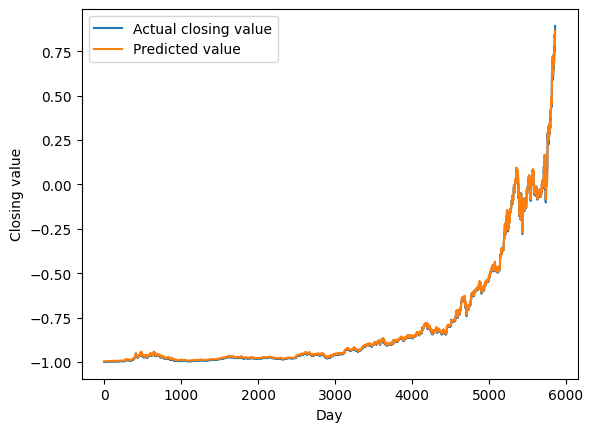

In [532]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual closing value')
plt.plot(predicted, label='Predicted value')
plt.xlabel('Day')
plt.ylabel('Closing value')
plt.legend()
plt.show()

In [533]:
train_prediction = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback))
dummies[:,0] = train_prediction
dummies = scaler.inverse_transform(dummies)

train_prediction = dc(dummies[:,0])
train_prediction

array([  0.48415726,   0.48586361,   0.48880941, ..., 170.64942473,
       172.08910089, 173.98400956])

In [534]:
dummies = np.zeros((X_train.shape[0], lookback))
dummies[:,0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

/tmp/ipython-input-1172147097.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:,0] = y_train.flatten()


array([7.50015923e-02, 7.91646265e-02, 7.65634249e-02, ...,
       1.72548002e+02, 1.74955992e+02, 1.76572494e+02])

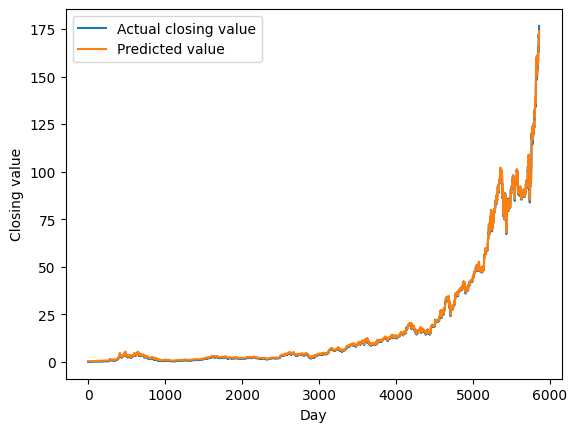

In [535]:
plt.plot(new_y_train, label='Actual closing value')
plt.plot(train_prediction, label='Predicted value')
plt.xlabel('Day')
plt.ylabel('Closing value')
plt.legend()
plt.show()

In [536]:
# Test stuff

test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback))
dummies[:,0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])
test_predictions

array([175.59129648, 171.57163963, 167.83381298, 161.92727339,
       163.61747639, 161.25854225, 158.47772435, 157.14029542,
       158.42341037, 156.29942921, 153.23860974, 150.44906002,
       149.7988819 , 155.15934701, 152.54190457, 152.38729426,
       154.87801705, 158.21061207, 158.37751139, 158.53645147,
       160.92309841, 158.67469311, 160.28534825, 157.63804758,
       159.83120513, 160.42091087, 163.5502231 , 169.20075553,
       171.3144097 , 169.80722458, 168.50876921, 166.07216586,
       163.14631429, 162.41221963, 161.13374016, 160.41075062,
       161.04338731, 161.34029113, 163.87954189, 160.90471214,
       161.41442537, 155.88583816, 153.01557893, 153.60794702,
       159.87384705, 164.40761916, 165.65844141, 160.8753986 ,
       155.67016075, 157.41735674, 157.06335988, 157.4836985 ,
       157.68374646, 157.91323025, 157.02466423, 157.10302265,
       156.5600496 , 156.34322166, 156.91410204, 159.23836461,
       160.34140748, 159.8411097 , 161.32741851, 161.33

In [537]:
dummies = np.zeros((X_test.shape[0], lookback))
dummies[:,0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])
new_y_test

/tmp/ipython-input-2460720397.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:,0] = y_test.flatten()


array([168.39999674, 164.73100188, 157.49200233, 163.43049557,
       158.75549155, 155.81100359, 155.14849755, 157.80650317,
       153.9050009 , 150.4364931 , 147.74550002, 148.02350066,
       156.44949298, 149.99299379, 150.98950412, 154.7564998 ,
       158.7025004 , 157.24400444, 157.43649336, 161.06300192,
       156.25000082, 159.96000907, 154.99800025, 159.78450022,
       159.52749817, 164.33250669, 172.14649963, 172.18150469,
       168.18550321, 166.93249662, 163.63549582, 160.36050519,
       160.85049265, 159.24699637, 158.82000468, 160.2200014 ,
       160.35200682, 164.31649929, 158.13900677, 160.55050963,
       151.80749309, 150.2240005 , 152.42050404, 162.05800044,
       166.1000065 , 165.56849431, 157.18699477, 151.75100589,
       156.86950922, 155.51400528, 156.44050549, 156.55299635,
       156.78300259, 155.27299395, 155.85099984, 154.96999843,
       154.91949732, 155.90300164, 159.25349382, 159.76699769,
       158.40199492, 161.00399689, 160.17649797, 159.33

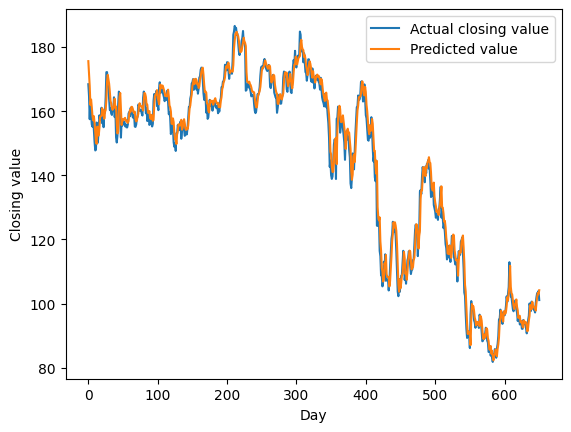

In [538]:
plt.plot(new_y_test, label='Actual closing value')
plt.plot(test_predictions, label='Predicted value')
plt.xlabel('Day')
plt.ylabel('Closing value')
plt.legend()
plt.show()